In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from keras.layers import Activation, Dense
from keras.models import Model
from keras.layers import Layer
import keras.backend as K
import keras

Using Keras 1.2, And tensor Flow 1.x

In [ ]:
from keras import models
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Input
from keras.layers import Dropout
from keras.layers import Conv1D, MaxPooling1D, Flatten, Conv2D, Reshape, ZeroPadding2D

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle


In [ ]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#De-Pickling Data with encoding latin1
with open("/content/drive/MyDrive/Colab Notebooks/DATA/Aditya/RML2016.10a_dict.pickle.pkl", 'rb') as f:
    Xd = pickle.load(f, encoding='latin1')

In [ ]:
classes = ['32PSK', '16APSK', '32QAM', 'FM', 'GMSK', '32APSK', 'OQPSK', #1
 '8ASK', 'BPSK','8PSK', 'AM-SSB-SC', '4ASK', '16PSK', '64APSK', '128QAM', '128APSK','AM-DSB-SC', #2 
'AM-SSB-WC', '64QAM', 'QPSK', '256QAM','AM-DSB-WC','OOK','16QAM']


In [ ]:
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [ ]:
np.random.seed(2016)  
n_examples = X.shape[0]
n_train = n_examples * 0.5  # 对半
train_idx = np.random.choice(range(0, n_examples), size=int(n_train), replace=False)
test_idx = list(set(range(0, n_examples)) - set(train_idx))  # label
X_train = X[train_idx]
X_test = X[test_idx]

In [ ]:
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy) + 1])
    yy1[np.arange(len(yy)), yy] = 1
    return yy1


In [ ]:
trainy = list(map(lambda x: mods.index(lbl[x][0]), train_idx))
Y_train = to_onehot(trainy)
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

In [ ]:
in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods

(110000, 2, 128) [2, 128]


In [ ]:
dr = 0.5  # dropout rate l

# Reshape [N,2,128] to [N,1,2,128] on input
input_x = Input(shape=(1, 2, 128))


In [ ]:
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [ ]:
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras import layers

In [ ]:
model = Sequential()
model = models.Sequential()
model.add(Reshape(in_shp+[1], input_shape=in_shp))
model.add(ZeroPadding2D((0,2)))

model.add(Conv2D(256, (1, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform', input_shape=(2, 128, 1)))
model.add(MaxPooling2D(pool_size=(1, 2), padding='valid',  data_format=None))
model.add(layers.Dropout(0.3))

model.add(Conv2D(256, (2, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform'))
model.add(MaxPooling2D(pool_size=(1, 2), padding='valid',  data_format=None))
model.add(layers.Dropout(0.3))
model.add(Conv2D(80, (1, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform'))
model.add(MaxPooling2D(pool_size=(1, 2), padding='valid',  data_format=None))
model.add(layers.Dropout(0.3))

model.add(Conv2D(80, (1, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform'))
model.add(MaxPooling2D(pool_size=(1, 2), padding='valid',  data_format=None))
model.add(layers.Dropout(0.3))

model.add(Reshape((2, 640)))

model.add(LSTM(50, activation='relu',return_sequences=True))
model.add(attention())
model.add(layers.Dropout(0.3))

model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
model.add(layers.Dropout(0.3))

model.add(Dense(11, activation='softmax', kernel_initializer='he_normal'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_10 (Reshape)         (None, 2, 128, 1)         0         
_________________________________________________________________
zero_padding2d_5 (ZeroPaddin (None, 2, 132, 1)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 2, 132, 256)       1024      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 2, 66, 256)        0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 2, 66, 256)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 2, 66, 256)        393472    
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 2, 33, 256)      

In [ ]:
# End of building, we will start fitting the neural network
# Set up some params
epochs = 100  # number of epochs to train on
batch_size = 1024  # training batch size default1024
filepath = "convmodrecnets_%s_0.5.wts.h5" % ('CNN_LSTM')



In [ ]:
history = model.fit(X_train,
                    Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, Y_test))

Epoch 1/100
108/108 [==============================] - 25s 217ms/step - loss: 2.3980 - accuracy: 0.0913 - val_loss: 2.3980 - val_accuracy: 0.0912
Epoch 2/100
108/108 [==============================] - 22s 207ms/step - loss: 2.3979 - accuracy: 0.0905 - val_loss: 2.3960 - val_accuracy: 0.1384
Epoch 3/100
108/108 [==============================] - 22s 207ms/step - loss: 2.3258 - accuracy: 0.1332 - val_loss: 2.0853 - val_accuracy: 0.1881
Epoch 4/100
108/108 [==============================] - 22s 205ms/step - loss: 1.9968 - accuracy: 0.2433 - val_loss: 1.7747 - val_accuracy: 0.3338
Epoch 5/100
108/108 [==============================] - 22s 205ms/step - loss: 1.7893 - accuracy: 0.3226 - val_loss: 1.7679 - val_accuracy: 0.3365
Epoch 6/100
108/108 [==============================] - 22s 206ms/step - loss: 1.6872 - accuracy: 0.3590 - val_loss: 1.5943 - val_accuracy: 0.3942
Epoch 7/100
108/108 [==============================] - 22s 205ms/step - loss: 1.5897 - accuracy: 0.3981 - val_loss: 1.5268 -

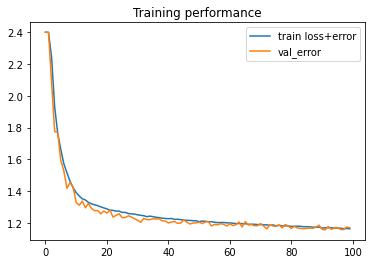

In [ ]:
# Show loss curves
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [ ]:
acc = {}
for snr in snrs:
  # extract classes @ SNR
  test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
  test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
  test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]
  # estimate classes
  test_Y_i_hat = model.predict(test_X_i)
  conf = np.zeros([len(classes),len(classes)])
  confnorm = np.zeros([len(classes),len(classes)])
  for i in range(0,test_X_i.shape[0]):
    j = list(test_Y_i[i,:]).index(1)
    k = int(np.argmax(test_Y_i_hat[i,:]))
    conf[j,k] = conf[j,k] + 1

  for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

  #plt.figure()
  #plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
  cor = np.sum(np.diag(conf))
  ncor = np.sum(conf) - cor
  print("SNR: ",snr, " Overall Accuracy: ", cor / (cor + ncor))
  acc[snr] = 1.0 * cor / (cor + ncor)

SNR:  -20  Overall Accuracy:  0.09533394327538884
SNR:  -18  Overall Accuracy:  0.09227974568574024
SNR:  -16  Overall Accuracy:  0.09388567293777135
SNR:  -14  Overall Accuracy:  0.09238542042583904
SNR:  -12  Overall Accuracy:  0.11485870556061988
SNR:  -10  Overall Accuracy:  0.19370890350097744
SNR:  -8  Overall Accuracy:  0.3408047032886276
SNR:  -6  Overall Accuracy:  0.5210777126099707
SNR:  -4  Overall Accuracy:  0.6628465804066543
SNR:  -2  Overall Accuracy:  0.7365747460087083
SNR:  0  Overall Accuracy:  0.7885036496350365
SNR:  2  Overall Accuracy:  0.7906215921483097
SNR:  4  Overall Accuracy:  0.8135095447870778
SNR:  6  Overall Accuracy:  0.814259927797834
SNR:  8  Overall Accuracy:  0.8140667267808837
SNR:  10  Overall Accuracy:  0.8262295081967214
SNR:  12  Overall Accuracy:  0.8030056128915445
SNR:  14  Overall Accuracy:  0.815095035984499
SNR:  16  Overall Accuracy:  0.8063348416289593
SNR:  18  Overall Accuracy:  0.8142214221422143


{-20: 0.09533394327538884, -18: 0.09227974568574024, -16: 0.09388567293777135, -14: 0.09238542042583904, -12: 0.11485870556061988, -10: 0.19370890350097744, -8: 0.3408047032886276, -6: 0.5210777126099707, -4: 0.6628465804066543, -2: 0.7365747460087083, 0: 0.7885036496350365, 2: 0.7906215921483097, 4: 0.8135095447870778, 6: 0.814259927797834, 8: 0.8140667267808837, 10: 0.8262295081967214, 12: 0.8030056128915445, 14: 0.815095035984499, 16: 0.8063348416289593, 18: 0.8142214221422143}


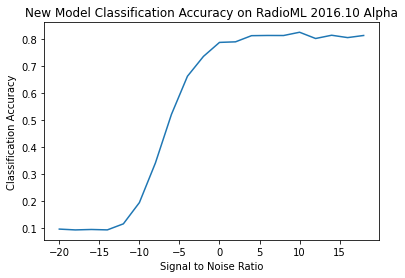

In [ ]:
print(acc)
fd = open('results_cnn_d0.5.dat','wb')
pickle.dump( ("CNN", 0.5, acc) , fd )

# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("New Model Classification Accuracy on RadioML 2016.10 Alpha")
plt.show()

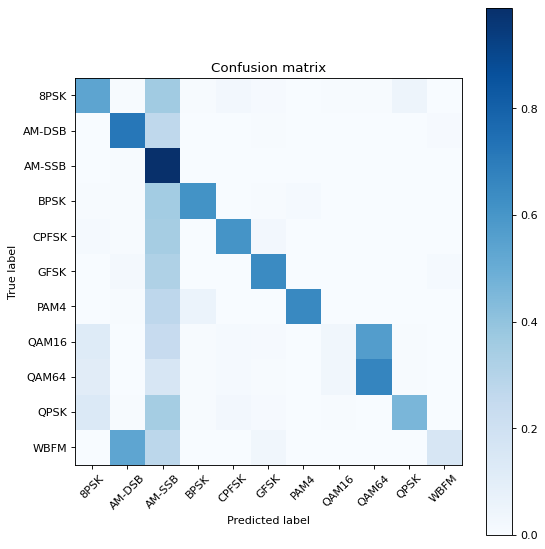

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

plt.figure(num=None, figsize=(7, 7), dpi=80, facecolor='w', edgecolor='black')
plot_confusion_matrix(confnorm, labels=classes)